In [1]:
# import lib
import numpy
import pandas

from matplotlib import pyplot

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import LSTM, Dense

In [2]:
csv_file = "./TESLA_STOCK_2010_2020.csv"
# Read the excel file to a dataframe
df = pandas.read_csv(csv_file)
# comment:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2416 entries, 0 to 2415
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2416 non-null   object 
 1   Open       2416 non-null   float64
 2   High       2416 non-null   float64
 3   Low        2416 non-null   float64
 4   Close      2416 non-null   float64
 5   Adj Close  2416 non-null   float64
 6   Volume     2416 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 132.2+ KB


In [3]:
# view dataframe
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.000000,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.420000,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.920000,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.100000,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.000000,15.830000,16.110001,16.110001,6866900
...,...,...,...,...,...,...,...
2411,2020-01-28,568.489990,576.809998,558.080017,566.900024,566.900024,11788500
2412,2020-01-29,575.690002,589.799988,567.429993,580.989990,580.989990,17801500
2413,2020-01-30,632.419983,650.880005,618.000000,640.809998,640.809998,29005700
2414,2020-01-31,640.000000,653.000000,632.520020,650.570007,650.570007,15719300


In [4]:
df['Date'] = pandas.to_datetime(df['Date'])
df.set_index('Date', inplace=True, verify_integrity=True)

In [5]:
# check if two columns Close and Adj Close is the same
(df['Close'] == df['Adj Close']).all()

True

In [6]:
# drop redudant column Adj Close
df.drop('Adj Close', axis=1, inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2416 entries, 2010-06-29 to 2020-02-03
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2416 non-null   float64
 1   High    2416 non-null   float64
 2   Low     2416 non-null   float64
 3   Close   2416 non-null   float64
 4   Volume  2416 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 113.2 KB


In [8]:
df

,Open,High,Low,Close,Volume
Date,,,,,
2010-06-29,19.000000,25.000000,17.540001,23.889999,18766300
2010-06-30,25.790001,30.420000,23.299999,23.830000,17187100
2010-07-01,25.000000,25.920000,20.270000,21.959999,8218800
2010-07-02,23.000000,23.100000,18.709999,19.200001,5139800
2010-07-06,20.000000,20.000000,15.830000,16.110001,6866900
...,...,...,...,...,...
2020-01-28,568.489990,576.809998,558.080017,566.900024,11788500
2020-01-29,575.690002,589.799988,567.429993,580.989990,17801500
2020-01-30,632.419983,650.880005,618.000000,640.809998,29005700


In [9]:
# Create scaler for scaling the data
scaler = MinMaxScaler(feature_range=(0,1))

In [10]:
df_train = df.copy(deep=True)
# df_train['Timestamp'] = [x.value / 86400000000000 for x in df.index]
df_train_col = df_train.columns
df_train[df_train_col] = scaler.fit_transform(df_train[df_train_col])

In [11]:
historical_day = 6
X = []
Y = []
for i in range(historical_day, len(df_train)):
    X.append(df_train.iloc[i - historical_day: i].to_numpy())
    Y.append(df_train['Open'].iloc[i])
X = numpy.array(X)
Y = numpy.array(Y).reshape(-1, 1)

# train_size = len(X) // 10 * 8
train_size = int(len(X)*0.8)

X_train = X[:train_size]
Y_train = Y[:train_size]

X_test = X[train_size:]
Y_test = Y[train_size:]

print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(1928, 6, 5) (1928, 1) (482, 6, 5) (482, 1)


In [12]:
# Create the model
model = Sequential()
# add LSTM layer
model.add(LSTM(units=150,\
        input_shape=X_train[0].shape))
# add Dense layer
model.add(Dense(units=Y_train.shape[1]))
# summary model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 150)               93600     
_________________________________________________________________
dense (Dense)                (None, 1)                 151       
Total params: 93,751
Trainable params: 93,751
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Select loss function and an optimizer 
model.compile(loss="mean_squared_error", optimizer="adam")

In [14]:
histories = model.fit (X_train, Y_train,\
            epochs=50,
            batch_size=32,
            validation_data=(X_test, Y_test),
            validation_batch_size=32,
            shuffle=False,
            verbose=1,
            use_multiprocessing=True)

Epoch 1/50
61/61 [==============================] - 6s 23ms/step - loss: 5.4741e-04 - val_loss: 0.0011
Epoch 2/50
61/61 [==============================] - 1s 12ms/step - loss: 5.1626e-04 - val_loss: 6.8790e-04
Epoch 3/50
61/61 [==============================] - 1s 12ms/step - loss: 1.6653e-04 - val_loss: 5.5516e-04
Epoch 4/50
61/61 [==============================] - 1s 12ms/step - loss: 1.3876e-04 - val_loss: 4.9249e-04
Epoch 5/50
61/61 [==============================] - 1s 12ms/step - loss: 1.3779e-04 - val_loss: 4.6347e-04
Epoch 6/50
61/61 [==============================] - 1s 12ms/step - loss: 1.3151e-04 - val_loss: 4.4251e-04
Epoch 7/50
61/61 [==============================] - 1s 11ms/step - loss: 1.2099e-04 - val_loss: 4.2746e-04
Epoch 8/50
61/61 [==============================] - 1s 12ms/step - loss: 1.1336e-04 - val_loss: 4.1539e-04
Epoch 9/50
61/61 [==============================] - 1s 12ms/step - loss: 1.0854e-04 - val_loss: 4.0370e-04
Epoch 10/50
61/61 [======================

<AxesSubplot:>

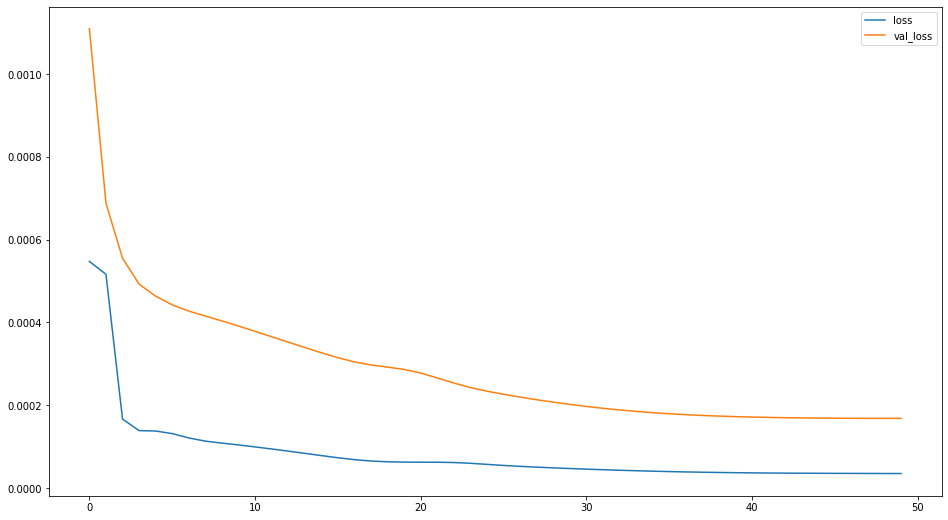

In [16]:
his_df = pandas.DataFrame(histories.history)
his_df.plot(figsize=(16,9))

In [17]:
Y_predict = model.predict(X)

In [18]:
scaler.fit(df[['Open']])
Y_predict = scaler.inverse_transform(Y_predict)

In [19]:
Y_predict

array([[ 12.64021 ],
       [ 13.783758],
       [ 14.442733],
       ...,
       [579.40546 ],
       [655.90204 ],
       [638.34265 ]], dtype=float32)

In [20]:
Open_Tomorrow_Predict = [None for i in range(historical_day)] + list(Y_predict.reshape(-1))
Open_Predict = [None] + Open_Tomorrow_Predict[:-1]

In [21]:
df['Open_Predict']  = Open_Predict
df['Open_Tomorrow_Predict'] = Open_Tomorrow_Predict
df['Open_Tomorrow_Real'] = df['Open'].shift(-1)
df['Loss'] = df['Open_Predict'] - df['Open']

In [22]:
df[-10:]

,Open,High,Low,Close,Volume,Open_Predict,Open_Tomorrow_Predict,Open_Tomorrow_Real,Loss
Date,,,,,,,,,
2020-01-21,530.250000,548.580017,528.409973,547.200012,17803500,502.439423,515.913696,571.890015,-27.810577
2020-01-22,571.890015,594.500000,559.099976,569.559998,31369000,515.913696,553.700195,564.250000,-55.976319
2020-01-23,564.250000,582.000000,555.599976,572.200012,19651000,553.700195,580.169128,570.630005,-10.549805
2020-01-24,570.630005,573.859985,554.260010,564.820007,14353600,580.169128,564.878052,541.989990,9.539123
2020-01-27,541.989990,564.440002,539.280029,558.020020,13608100,564.878052,565.153625,568.489990,22.888062
2020-01-28,568.489990,576.809998,558.080017,566.900024,11788500,565.153625,548.473816,575.690002,-3.336365
2020-01-29,575.690002,589.799988,567.429993,580.989990,17801500,548.473816,574.193604,632.419983,-27.216186
2020-01-30,632.419983,650.880005,618.000000,640.809998,29005700,574.193604,579.405457,640.000000,-58.226379
2020-01-31,640.000000,653.000000,632.520020,650.570007,15719300,579.405457,655.902039,673.690002,-60.594543


In [23]:
df[:10]

,Open,High,Low,Close,Volume,Open_Predict,Open_Tomorrow_Predict,Open_Tomorrow_Real,Loss
Date,,,,,,,,,
2010-06-29,19.000000,25.000000,17.540001,23.889999,18766300,NaN,NaN,25.790001,NaN
2010-06-30,25.790001,30.420000,23.299999,23.830000,17187100,NaN,NaN,25.000000,NaN
2010-07-01,25.000000,25.920000,20.270000,21.959999,8218800,NaN,NaN,23.000000,NaN
2010-07-02,23.000000,23.100000,18.709999,19.200001,5139800,NaN,NaN,20.000000,NaN
2010-07-06,20.000000,20.000000,15.830000,16.110001,6866900,NaN,NaN,16.400000,NaN
2010-07-07,16.400000,16.629999,14.980000,15.800000,6921700,NaN,NaN,16.139999,NaN
2010-07-08,16.139999,17.520000,15.570000,17.459999,7711400,NaN,12.640210,17.580000,NaN
2010-07-09,17.580000,17.900000,16.549999,17.400000,4050600,12.640210,13.783758,17.950001,-4.939790
2010-07-12,17.950001,18.070000,17.000000,17.049999,2202500,13.783758,14.442733,17.389999,-4.166243


In [ ]:
model.evaluate(X_test, Y_test)

<AxesSubplot:xlabel='Date'>

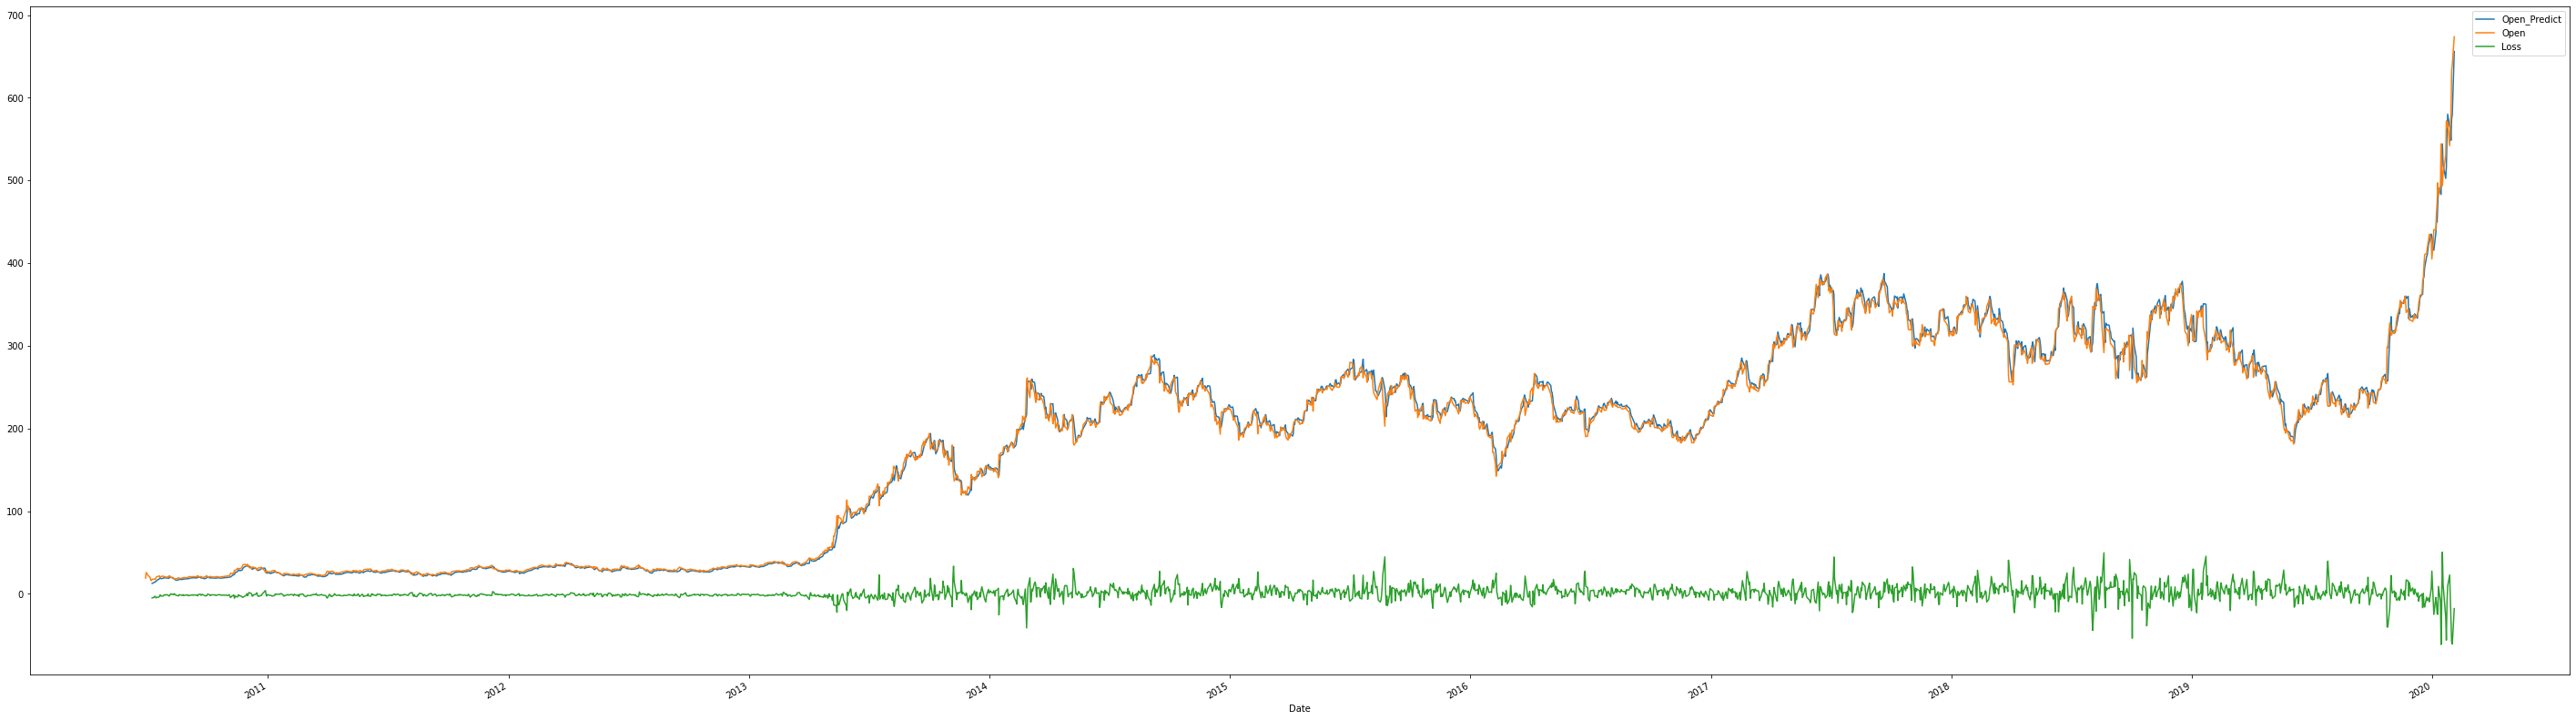

In [31]:
df.plot(y={'Open', 'Open_Predict', 'Loss'}, figsize=(50,15))

<AxesSubplot:ylabel='Frequency'>

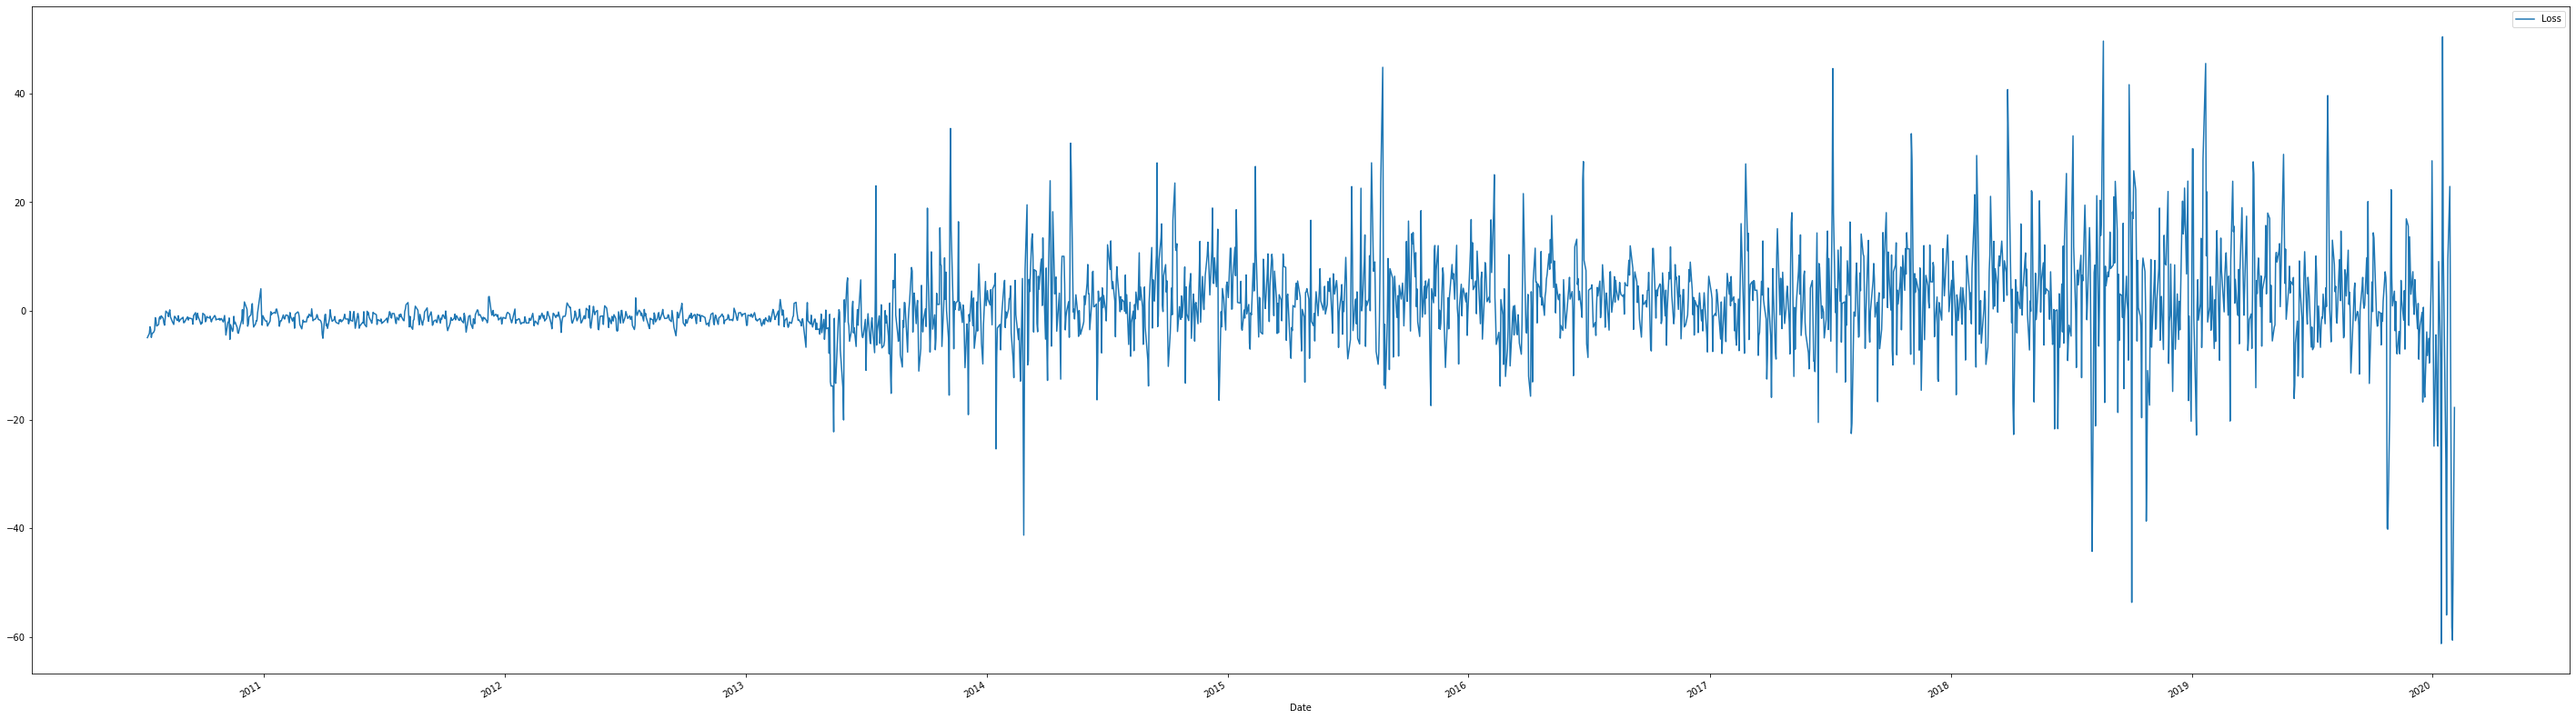

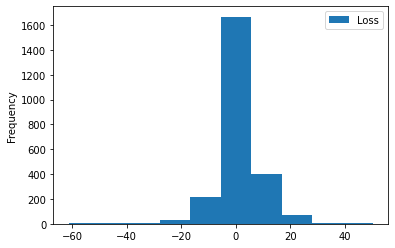

In [36]:
df.plot(y='Loss', figsize=(50,15), kind='line')
df.plot(y='Loss', kind='hist')